In [8]:
import warnings
# Es importante importar esto específicamente
from sklearn.exceptions import ConvergenceWarning
# Filtrar exactamente esta categoría de warning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import itertools
from multiprocessing import Pool, cpu_count
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [2]:
def load_data():
    import os
    import pickle

    dataset_file = "mnist_dataset.pkl"

    if os.path.exists(dataset_file):
        print(f"Loading dataset from {dataset_file}")
        with open(dataset_file, 'rb') as f:
            data = pickle.load(f)
            X, y = data["data"], data["target"]
    
    else:
        print("Dataset not found, downloading it")
        mnist = fetch_openml('mnist_784', as_frame=False)
        X, y = mnist.data, mnist.target
        
        print(f"Saving dataset to {dataset_file}")
        with open(dataset_file, 'wb') as f:
            pickle.dump({"data": X, "target": mnist.target}, f)

    y = y.astype(np.uint8)
    return X, y
    

In [3]:
def evaluate_model(params):
    alpha, loss, penalty, eta0, X_train, y_train, X_val, y_val = params

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    model = SGDClassifier(
        alpha=alpha,
        loss=loss,
        penalty=penalty,
        learning_rate="constant",
        eta0=eta0,
        max_iter=100,
        random_state=42,
        n_jobs=1,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=5,
        tol=1e-3
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    print(f"Evaluated: alpha={alpha}, loss={loss}, penalty={penalty}, eta0={eta0}, accuracy={accuracy}")

    return {
        "alpha": alpha,
        "loss": loss,
        "penalty": penalty,
        "eta0": eta0,
        "accuracy": accuracy
    }

In [4]:
def run_grid_search(n_procesors, params_list):
    start_time = time.time()
    if n_procesors == 1:
        results = []
        for params in params_list:
            results.append(evaluate_model(params))
    else:
        with Pool(n_procesors) as pool:
            results = pool.map(evaluate_model, params_list)
    end_time = time.time()
    execution_time = end_time - start_time
    
    best_params = max(results, key=lambda x: x['accuracy'])
    print(f"Best parameters with {n_procesors} processors: {best_params}")
    print(f"Time taken with {n_procesors} processors: {execution_time:.2f} seconds")
    
    return execution_time, best_params

In [5]:
X, y = load_data()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

params = {
        'alpha': [0.0001, 0.01], 
        'loss': ['log_loss', 'hinge'], 
        'penalty': ['l2'], 
        'eta0': [0.01, 0.1]  
    }

param_combinations = list(itertools.product(
    params['alpha'],
    params['loss'],
    params['penalty'],
    params['eta0']
))

print(f"Total combinations: {len(param_combinations)}")

params_list = [(alpha, loss, penalty, eta0, X_train, y_train, X_val, y_val) 
              for alpha, loss, penalty, eta0 in param_combinations]
results_data = {
    'n_procesors': [],
    'execution_time': [],
    'speedup': [],
    'efficiency': []
}

Loading dataset from mnist_dataset.pkl
Total combinations: 8


In [6]:
max_processors = cpu_count()
processor_counts = [1, 2, 4, 8] 
processor_counts = [p for p in processor_counts if p <= max_processors]
print(f"Maximum available processors: {max_processors}")
print(f"Will test with processors: {processor_counts}")

print(f"\nRunning with 1 processor (sequential)...")
sequential_time, _ = run_grid_search(1, params_list)
print(f"Sequential execution time: {sequential_time:.2f} seconds")

results_data['n_procesors'].append(1)
results_data['execution_time'].append(sequential_time)
results_data['speedup'].append(1.0)
results_data['efficiency'].append(1.0)

for n_proc in processor_counts:
    if n_proc == 1:
        continue
        
    print(f"\nRunning with {n_proc} processors...")
    execution_time, _ = run_grid_search(n_proc, params_list)
    
    # Calcular speedup y eficiencia
    speedup = sequential_time / execution_time
    efficiency = speedup / n_proc
    
    # Guardar resultados
    results_data['n_procesors'].append(n_proc)
    results_data['execution_time'].append(execution_time)
    results_data['speedup'].append(speedup)
    results_data['efficiency'].append(efficiency)
    
    print(f"Speedup with {n_proc} processors: {speedup:.2f}")
    print(f"Efficiency with {n_proc} processors: {efficiency:.2f}")

Maximum available processors: 16
Will test with processors: [1, 2, 4, 8]

Running with 1 processor (sequential)...
Evaluated: alpha=0.0001, loss=log_loss, penalty=l2, eta0=0.01, accuracy=0.8939285714285714
Evaluated: alpha=0.0001, loss=log_loss, penalty=l2, eta0=0.1, accuracy=0.8689285714285714
Evaluated: alpha=0.0001, loss=hinge, penalty=l2, eta0=0.01, accuracy=0.8850714285714286
Evaluated: alpha=0.0001, loss=hinge, penalty=l2, eta0=0.1, accuracy=0.8785
Evaluated: alpha=0.01, loss=log_loss, penalty=l2, eta0=0.01, accuracy=0.8706428571428572
Evaluated: alpha=0.01, loss=log_loss, penalty=l2, eta0=0.1, accuracy=0.763
Evaluated: alpha=0.01, loss=hinge, penalty=l2, eta0=0.01, accuracy=0.846
Evaluated: alpha=0.01, loss=hinge, penalty=l2, eta0=0.1, accuracy=0.7828571428571428
Best parameters with 1 processors: {'alpha': 0.0001, 'loss': 'log_loss', 'penalty': 'l2', 'eta0': 0.01, 'accuracy': 0.8939285714285714}
Time taken with 1 processors: 62.57 seconds
Sequential execution time: 62.57 second


Results summary:
   n_procesors  execution_time   speedup  efficiency
0            1       62.566380  1.000000    1.000000
1            2       54.839734  1.140895    0.570448
2            4       46.215286  1.353803    0.338451
3            8       44.119481  1.418112    0.177264


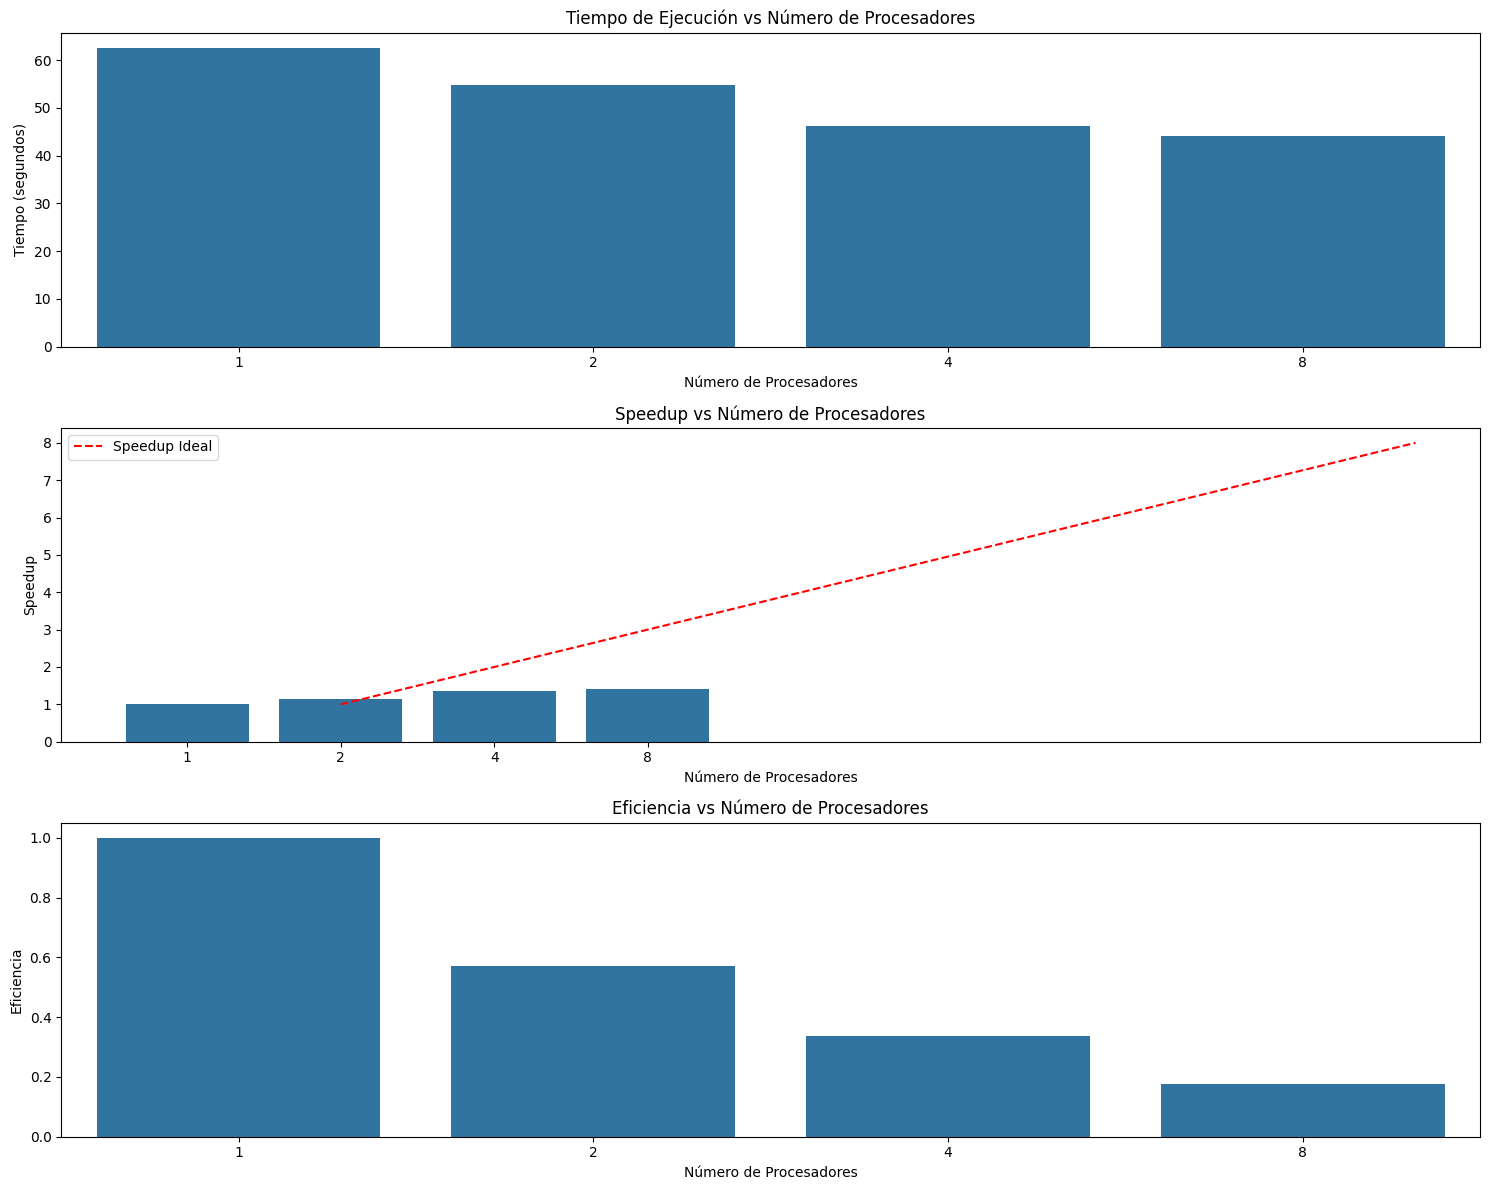

In [7]:
results_df = pd.DataFrame(results_data)
print("\nResults summary:")
print(results_df)

plt.figure(figsize=(15, 12))

plt.subplot(3, 1, 1)
sns.barplot(x='n_procesors', y='execution_time', data=results_df)
plt.title('Tiempo de Ejecución vs Número de Procesadores')
plt.xlabel('Número de Procesadores')
plt.ylabel('Tiempo (segundos)')

plt.subplot(3, 1, 2)
sns.barplot(x='n_procesors', y='speedup', data=results_df)
plt.title('Speedup vs Número de Procesadores')
plt.xlabel('Número de Procesadores')
plt.ylabel('Speedup')

x = np.array(results_df['n_procesors'])
y_ideal = x 
plt.plot(x, y_ideal, 'r--', label='Speedup Ideal')
plt.legend()

plt.subplot(3, 1, 3)
sns.barplot(x='n_procesors', y='efficiency', data=results_df)
plt.title('Eficiencia vs Número de Procesadores')
plt.xlabel('Número de Procesadores')
plt.ylabel('Eficiencia')

plt.tight_layout()
plt.savefig('performance_metrics.png')
plt.show()